# Load Images and Measurements

## Utilities

In [2]:
import csv
from os.path import isfile
from sklearn.model_selection import train_test_split

"""Checks whether a file exists at the given path.
Returns a tuple with the format(Exists, Full File Name)

Keyword arguments:
file_name -- Name of the file to check
base_path -- Directory path to check under
"""
def file_exists(file_name, img_dirs):
    for base_path in img_dirs:
        full_name = "/".join([".", base_path, file_name])
        if isfile(full_name):
            return (True, full_name)
        
    return (False, None)


"""Processes the full name by extracting the image name of files that exist and its corresponding steering mewasurement

Keyword arguments:
image_names -- Output array of image names
measurements -- Output array of steering measurements
file_name -- Name of the file to process
measurement -- Steering measurement corresponding to the file.
img_dirs -- Directories under which image data exists.
"""
def process_image_file(image_names, measurements, file_name, measurement, img_dirs):
    is_present, full_name = file_exists(file_name, img_dirs)
    if is_present:
            image_names.append(full_name)
            measurements.append(measurement)
    return is_present
    
"""Loads the driving log file data into memory.
Returns a tuple of image names, steering measurements and measurement classes (0 if measurement is 0, 1 otherwise)
"""
def load_log_files():
    # log file directories
    log_dirs = ['Simulator_Images_7', 'Simulator_Images_6', 'Simulator_Images_5', 'Simulator_Images_4', 'Simulator_Images_0']
    # image data directories
    img_dirs = ["/".join([log_dir, "IMG"]) for log_dir in log_dirs]
    # log file paths
    log_files = ["/".join([log_dir, "driving_log.csv"]) for log_dir in log_dirs]
    
    # output image names
    image_names = []
    # output steering measurements
    measurements = []
    # Whether the output is 0 or non-zero. 
    # Used for stratified validation split such that the training and validation data have equal propotion of 0 measurements.
    measurement_class = []
    
    # angle correction factor to use for left and right cameras
    angle_correction_factor = 0.025

    
    for log_file in log_files:
        with open(log_file, 'r') as csv_file:
            filereader = csv.reader(csv_file)
            
            for row in filereader:
                if '\\' in row[0]:
                    # windows style path
                    center_file_name = row[0].split('\\')[-1]
                    left_file_name =   row[1].split('\\')[-1]
                    right_file_name =  row[2].split('\\')[-1]
                else:
                    # unix style path
                    center_file_name = row[0].split('/')[-1]
                    left_file_name =   row[1].split('/')[-1]
                    right_file_name =  row[2].split('/')[-1]
                    
                center_measurement = float(row[3])
                # left camera needs to move clockwise (+ve) towards centre
                left_measurement =  center_measurement + angle_correction_factor
                # right camera needs to move anti-clockwise(-ve) towards centre
                right_measurement = center_measurement - angle_correction_factor
                                   
                if process_image_file(image_names, measurements, center_file_name, center_measurement, img_dirs):
                    # capture the measurement class
                    if center_measurement > 0 or center_measurement < 0:
                        measurement_class.append(1)
                    else:
                        measurement_class.append(0)
                    
                if process_image_file(image_names, measurements, left_file_name, left_measurement, img_dirs):
                    # capture the measurement class
                    if center_measurement > 0 or center_measurement < 0:
                        measurement_class.append(1)
                    else:
                        measurement_class.append(0)
                if process_image_file(image_names, measurements, right_file_name, right_measurement, img_dirs):
                    # capture the measurement class
                    if center_measurement > 0 or center_measurement < 0:
                        measurement_class.append(1)
                    else:
                        measurement_class.append(0)


    print ("Number of images: {}".format(len(image_names)))
    print ("Measurement classes: {}".format(len(measurement_class)))
    return (image_names, measurements, measurement_class)


"""Get the training and validation data.
Returns training and validation data sets as a list of tuples of image names and steering measurements.
"""
def get_train_validation_data():
    validation_size = 0.3 # 30%
    image_names, image_measurements, measurement_class =  load_log_files()
    train_image_samples, validation_image_samples, train_angle_samples, validation_angle_samples = train_test_split(
         image_names, image_measurements, test_size=validation_size, random_state=42, stratify=measurement_class)
    return list(zip(train_image_samples, train_angle_samples)), list(zip(validation_image_samples, validation_angle_samples))

## Generator

In [3]:
from sklearn.utils import shuffle
import numpy as np
import cv2
from math import ceil
import random
from skimage import exposure
from scipy import ndimage

"""Resize the image to the given width and height

Keyword arguments: 
img -- Image to resize
width -- Width desired
height - height desired
"""
def resize_image(img, target_width, target_height):
    num_rows = len(img[:, 0, 0])
    crop_top_rows = 50
    crop_bottom_rows = 20
    img = img[crop_top_rows:(num_rows - crop_bottom_rows), :, :]
    img = cv2.resize(img, (target_width, target_height), interpolation = cv2.INTER_CUBIC)
    return img

"""Read an image at the given path

image_path -- Image path to read from
target_width -- Image width desired
target_height -- Image height desired
"""
def read_image(image_path, target_width, target_height):
    img = resize_image(cv2.imread(image_path), target_width, target_height)
    return img

"""A generator for generating sample data for training and validation.
The generator retrieves image data from the image name data set and resizes according to 
the parameters specified. 
The generator also performs the following image modifications at random:
1) Horizontal flip
2) Contrast stretch
3) Gaussian blur

Finally the image data is zero-centered and normalized.

Keyword arguments:
samples -- Data to set to generate from
batch_size -- Batch size of each generated set
target_width -- Target width of images desired (defaults to 224)
targert_height -- Target height of images desired (defaults to 64)
"""
def sample_generator(samples, batch_size, target_width=224, target_height=64):
    num_samples = len(list(samples))
        
    while 1:
        # shuffle at the begining of every pass
        shuffle(samples)
        
        for i in range(0, num_samples, batch_size):
            batch_samples = samples[i : i + batch_size]
            
            images = []
            angles = []
            for sample in batch_samples:
                # random image modifications
                do_flip = random.randint(0,1) # flip image horizontally
                do_contrast = random.randint(0,1) # contrast stretch the image
                do_blur = random.randint(0,1) # gaussian blur the image

                img = read_image(sample[0], target_width, target_height)
                steering_angle = float(sample[1])
                
                if do_flip:
                    img = cv2.flip(img,1)
                    steering_angle = -1.0 * steering_angle
                
                if do_blur:
                    img = ndimage.gaussian_filter(img, sigma=5)
                elif do_contrast:
                    # contrast stretch
                    low_percentile, high_percentile = np.percentile(img, (0.2, 99.8))
                    img = exposure.rescale_intensity(img, in_range=(low_percentile, high_percentile))
                    
                images.append(img)
                angles.append(steering_angle)
        
            image_set = np.array(images, dtype=np.float32)
            
            # zero-centering and normalization
            image_set /= 255.0
            image_set -= 0.5
            angle_set = np.array(angles, dtype=np.float32)
            
            yield shuffle(image_set, angle_set)

## Load training and validatiom data

In [4]:
train_data, val_data = get_train_validation_data()
train_sample_size = len(train_data)
val_sample_size = len(val_data)
print ("Training samples: {}".format(train_sample_size))
print ("Validation samples: {}".format(val_sample_size))

Number of images: 44662
Measurement classes: 44662
Training samples: 31263
Validation samples: 13399


# Model Architecture

## VGG 19

In [ ]:
### Reference: https://github.com/fchollet/keras/blob/master/keras/applications/vgg19.py

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

# save model to this file at the end of every epoch
model_save_file='model-{epoch:02d}-{val_loss:.4f}.h5'

# start with VGG convolutions
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# add dense layers to the end (feature extraction)
x = base_model.get_layer('block5_pool').output
x = SpatialDropout2D(p=0.5)(x)
x = Flatten(name='custom_flatten')(x)

x = Dense(512, name='custom_fc1')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.5)(x)

x = Dense(64, name='custom_fc2', W_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dropout(0.2)(x)

x = Dense(10, name='custom_fc3', W_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

predictions = Dense(1, activation='linear', name='custom_predictions')(x)

model = Model(input=base_model.input, output=predictions)
print (model.summary())

# training
batch_size=128
train_generator = sample_generator(train_data, batch_size = batch_size)
validation_generator = sample_generator(val_data, batch_size = batch_size)

opt = Adam(lr=0.001, beta_1=0.9)
model.compile(loss='mse', optimizer=opt)
# stop if loss has stopped decreasing
early_stopper = EarlyStopping(monitor='loss', min_delta=1e-4)
# save the model after each epoch
checkpointer = ModelCheckpoint(filepath=model_save_file, save_best_only=False)

# train/fit
hist = model.fit_generator(train_generator, samples_per_epoch = train_sample_size, nb_epoch=14, verbose=1,
                           validation_data=validation_generator, nb_val_samples = val_sample_size,
                          callbacks = [early_stopper, checkpointer])

### plt the training and validation loss for each epoch
plt.figure(1)
loss_plot = plt.subplot(1,1,1)
loss_plot.set_title("MSE Loss")
loss_plot.plot(hist.history['loss'], label='training')
loss_plot.plot(hist.history['val_loss'], label='validation')
loss_plot.set_ylabel('MSE')
loss_plot.set_xlabel('Epoch')
loss_plot.legend(loc = 'upper right')
plt.show()

## Test sample predictions

In [ ]:
from keras.models import load_model
import random
#model = load_model("model_vgg_201708091340.h5")

x_p = []
y_a = []
for i in range(0, 10):
    idx = random.randint(0, len(train_data) - 1)
    sample = train_data[idx]
    img = read_image(sample[0], 224, 64)
    x_p.append(img)
    y_a.append(float(sample[1]))

image_set = np.array(x_p, dtype=np.float32)
image_set /= 255.0
image_set -= .5

predictions = model.predict(image_set)
predictions /= 1.0
y_a = [y/1.0 for y in y_a]
print ("Predictions: {}".format(predictions))
print ("Actual: ")
for y in y_a:
    print (y)

## Model Visualization

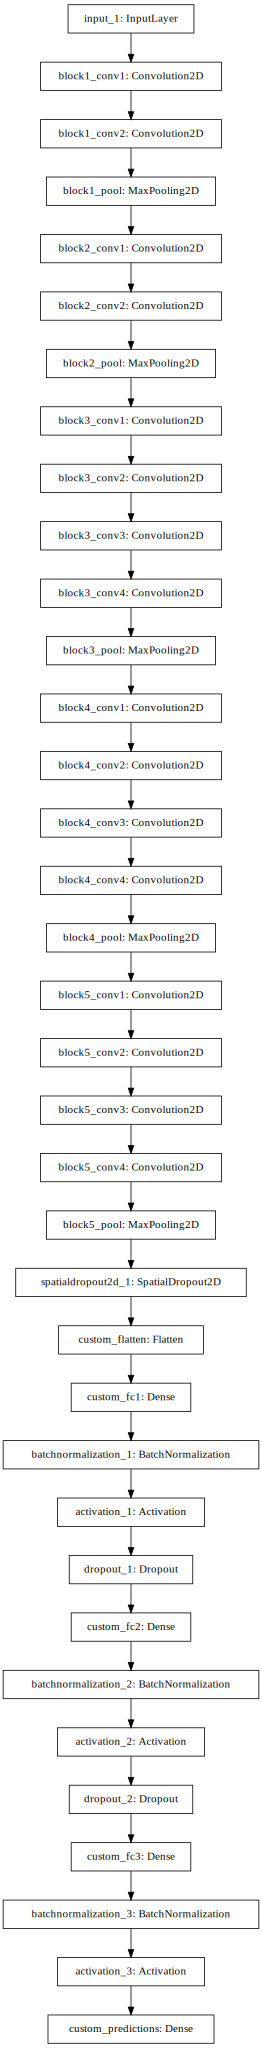

In [7]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
from keras.models import load_model

model = load_model('model-06-0.0178.h5')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [8]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')